In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import os
import time
import gc
from glob import glob
from tqdm import tqdm_notebook as tqdm
import pickle

import base64
import swifter
import gensim

from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from keras.preprocessing.sequence import pad_sequences

# import category_encoders as ce

pd.set_option('display.max_columns', 1200)

Using TensorFlow backend.


In [2]:
DATA_DIR = 'D:/project/ICF_AutoCapsule_disabled/kddcup2020/input/'
W2V_DIR = 'D:/project/ICF_AutoCapsule_disabled/kddcup2020/w2v/'

In [3]:
train = pd.read_csv(DATA_DIR+'multimodal_train_sampleset/train.sample.tsv', sep='\t')
print(train.shape)
train.head()Jupyter Notebook
Untitled
(unsaved changes)
Current Kernel Logo
Python 3 
File
Edit
View
Insert
Cell
Kernel
Widgets
Help

import pandas as pd
import numpy as np
import datetime
import random
import os
import time
import gc
from glob import glob
from tqdm import tqdm_notebook as tqdm
import pickle
​
import base64
import swifter
import gensim
​
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
​
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from keras.preprocessing.sequence import pad_sequences
​
pd.set_option('display.max_columns', 1200)
DATA_DIR = '~/mnt/data/'


(10000, 9)


,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id
0,102851856,338,209,2,AAAAAAAAQEAAAKlDAABPQwAAb0MAALBBAICmQwAATEM=,AAAAAAAAAAAnNsFAAAAAAOeVGD0AAAAAAAAAAAAAAAAAAA...,HAAAAAAAAAAcAAAAAAAAAA==,treble popular reed,923271
1,101783080,80,61,1,AACgQAAAoEAAAJZCAABgQg==,AAAAADnKfjyatb8/AAAAALxPBz0MH6E9xwkoPAAAAAAAAA...,HAAAAAAAAAA=,compatible ink cartridges,234031
2,100492797,750,750,1,AAAsQgCAg0MAgCREAADqQw==,AAAAAAAAAABmUlE/AAAAABvc0jwAAAAAAAAAAAAAAAAAAA...,BwAAAAAAAAA=,check new look facial cream,199926
3,101708088,480,640,5,AAB6QwCA0kMAANBDAMAeRAAAfEMAAKBAAIDWQwAAVkMAAH...,AAAAAAAAAAAAAAAAAAAAAAXyfz4AAAAAAAAAAAAAAAAAAA...,HAAAAAAAAAAcAAAAAAAAABwAAAAAAAAAHAAAAAAAAAAcAA...,royal commemorative stamp,772725
4,100316842,800,800,4,AAAKQwCAgEMAADNEAAAHRAAAIkMAwCZEAACqQwDARkQAAE...,AAAAADSdaTwVTdA8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,HAAAAAAAAAAGAAAAAAAAAAYAAAAAAAAAHAAAAAAAAAA=,calendula baby shower gel,362576


In [4]:
valid = pd.read_csv(DATA_DIR+'multimodal_valid/valid.tsv', sep='\t')
print(valid.shape)
valid.head()

(14720, 9)


,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id
0,103047314,800,800,2,AACoQgAA5EIAAKdDAIDuQwCAq0MAAJBCAMA3RABAHkQ=,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,BAAAAAAAAAAEAAAAAAAAAA==,breathable and comfortable children's shoes,0
1,103030678,800,800,9,AIDRQwAAoEAAwEJEAABpQwAAA0MAgMlDAABHRAAAIkQAgL...,AAAAAAAAAACdFBI7AAAAAAAAAABu+j0+AAAAAAAAAAAAAA...,BAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAHQAAAAAAAAAEAA...,breathable and comfortable children's shoes,0
2,103031217,488,750,2,AABGQwAANEIAgNNDAADsQwAAUEIAALVDAADRQwCALEQ=,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,BAAAAAAAAAAEAAAAAAAAAA==,breathable and comfortable children's shoes,0
3,103026621,929,800,10,AACtQwCAA0QAgPxDAIAoRAAAekMAALdDAACwQwCA30MAgK...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,HAAAAAAAAAAdAAAAAAAAAAAAAAAAAAAACQAAAAAAAAAJAA...,breathable and comfortable children's shoes,0
4,103017048,800,800,2,AAA+QwCAi0MAgAtEAMA0RAAAqEMAAHhCAMA1RABADUQ=,AAAAAAAAAADIb2s9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,BAAAAAAAAAAEAAAAAAAAAA==,breathable and comfortable children's shoes,0


In [5]:
def transform_boxes(df_row):
    return np.frombuffer(base64.b64decode(df_row.boxes), dtype=np.float32).reshape(df_row.num_boxes, 4)

def transform_features(df_row):
    return np.frombuffer(base64.b64decode(df_row.features), dtype=np.float32).reshape(df_row.num_boxes, 2048)

def transform_class_labels(df_row):
    return np.frombuffer(base64.b64decode(df_row.class_labels), dtype=np.int64).reshape(df_row.num_boxes)

In [6]:
train.boxes = train.swifter.apply(transform_boxes, axis=1)
train.features = train.swifter.apply(transform_features, axis=1)
train.class_labels = train.swifter.apply(transform_class_labels, axis=1)

In [7]:
valid.boxes = valid.swifter.apply(transform_boxes, axis=1)
valid.features = valid.swifter.apply(transform_features, axis=1)
valid.class_labels = valid.swifter.apply(transform_class_labels, axis=1)

In [8]:
train.head()

,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id
0,102851856,338,209,2,"[[0.0, 3.0, 338.0, 207.0], [239.0, 22.0, 333.0...","[[0.0, 0.0, 6.0378604, 0.0, 0.037252333, 0.0, ...","[28, 28]",treble popular reed,923271
1,101783080,80,61,1,"[[5.0, 5.0, 75.0, 56.0]]","[[0.0, 0.015551143, 1.4977295, 0.0, 0.03303502...",[28],compatible ink cartridges,234031
2,100492797,750,750,1,"[[43.0, 263.0, 658.0, 468.0]]","[[0.0, 0.0, 0.81766355, 0.0, 0.02573972, 0.0, ...",[7],check new look facial cream,199926
3,101708088,480,640,5,"[[250.0, 421.0, 416.0, 635.0], [252.0, 5.0, 42...","[[0.0, 0.0, 0.0, 0.0, 0.24994667, 0.0, 0.0, 0....","[28, 28, 28, 28, 28]",royal commemorative stamp,772725
4,100316842,800,800,4,"[[138.0, 257.0, 716.0, 540.0], [162.0, 667.0, ...","[[0.0, 0.014258672, 0.02542738, 0.0, 0.0, 0.0,...","[28, 6, 6, 28]",calendula baby shower gel,362576


In [9]:
train.tail()

,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id
9995,100567061,800,800,3,"[[343.0, 46.0, 557.0, 165.0], [255.0, 246.0, 4...","[[0.0, 0.0, 0.04133281, 0.0, 0.0, 0.256621, 0....","[8, 5, 5]",uv for men and women glasses,618985
9996,101549782,800,800,5,"[[173.0, 5.0, 555.0, 400.0], [109.0, 385.0, 22...","[[0.0, 0.0, 0.32368466, 0.0, 0.057625342, 0.0,...","[28, 28, 28, 28, 28]",pull universal shower accessories,1292191
9997,100297341,800,800,11,"[[160.0, 135.0, 795.0, 682.0], [346.0, 271.0, ...","[[0.010029581, 0.06795592, 1.4334337, 0.013566...","[20, 28, 28, 20, 20, 28, 28, 28, 28, 28, 28]",silicone accessories storage box,1068367
9998,102303485,800,800,2,"[[479.0, 245.0, 677.0, 530.0], [319.0, 85.0, 6...","[[0.0, 0.0, 0.74862194, 0.0, 0.7302371, 0.0, 0...","[28, 28]",applicable motor,1263055
9999,101749116,756,1008,1,"[[26.0, 28.0, 732.0, 1008.0]]","[[0.0, 0.0, 0.6832453, 0.0, 0.06689272, 0.0037...",[28],restaurant colander,662058


In [10]:
valid.tail(20)

,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id
14700,103040723,800,800,3,"[[42.0, 145.0, 746.0, 628.0], [5.0, 334.0, 90....","[[0.0, 0.0, 0.048357625, 0.0, 0.0, 0.0, 0.0710...","[0, 29, 2]",men's high collar sweater,500
14701,103060709,394,394,1,"[[8.0, 31.0, 372.0, 371.0]]","[[0.0, 0.0, 0.6290011, 0.0, 0.06375528, 0.1264...",[0],men's high collar sweater,500
14702,103009291,1000,1000,1,"[[0.0, 3.0, 993.0, 998.0]]","[[0.0, 0.0, 3.933092, 0.0, 0.05122487, 0.0, 0....",[0],men's high collar sweater,500
14703,103029329,1000,1000,2,"[[58.0, 306.0, 657.0, 712.0], [448.0, 341.0, 9...","[[0.0, 0.0, 4.269327, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2]",men's high collar sweater,500
14704,103022067,829,690,3,"[[230.0, 334.0, 387.0, 431.0], [290.0, 178.0, ...","[[0.0, 0.0, 0.7738576, 0.0, 0.3267151, 0.01661...","[3, 0, 2]",men's high collar sweater,500
14705,103057030,800,800,2,"[[5.0, 311.0, 95.0, 479.0], [55.0, 175.0, 783....","[[0.0, 0.0, 1.316205, 0.0, 0.0, 0.0, 0.0, 0.0,...","[29, 0]",men's high collar sweater,500
14706,103042318,800,800,1,"[[43.0, 0.0, 800.0, 609.0]]","[[0.0, 0.0, 4.088087, 0.004948093, 0.0, 0.0, 0...",[0],men's high collar sweater,500
14707,103035563,1000,750,5,"[[159.0, 373.0, 242.0, 420.0], [13.0, 253.0, 1...","[[0.0, 0.0, 0.09739708, 0.0, 0.0, 0.0, 0.0, 0....","[5, 5, 1, 4, 29]",men's high collar sweater,500
14708,103044806,800,800,3,"[[679.0, 132.0, 753.0, 210.0], [15.0, 254.0, 1...","[[0.0, 0.0, 0.16328086, 0.0, 0.0, 0.0, 0.0, 0....","[3, 29, 0]",men's high collar sweater,500
14709,103007689,531,800,2,"[[99.0, 418.0, 527.0, 613.0], [68.0, 465.0, 15...","[[0.0, 0.0, 0.079813905, 0.0, 0.0, 0.0, 0.0748...","[1, 5]",men's high collar sweater,500


In [11]:
print(valid.query_id.nunique())
valid.query_id.value_counts(dropna=False)

496


495    30
266    30
282    30
290    30
298    30
       ..
415    17
448    17
323    17
351    15
425     9
Name: query_id, Length: 496, dtype: int64

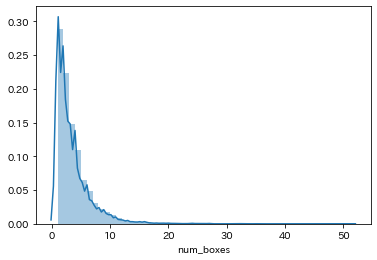

In [12]:
sns.distplot(train.num_boxes)

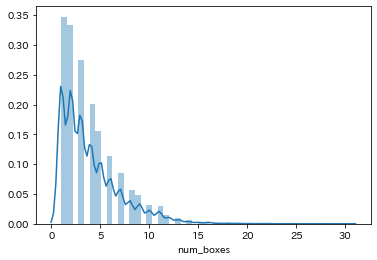

In [13]:
sns.distplot(valid.num_boxes)

In [14]:
train.num_boxes.max()

51

In [15]:
valid.num_boxes.max()

30

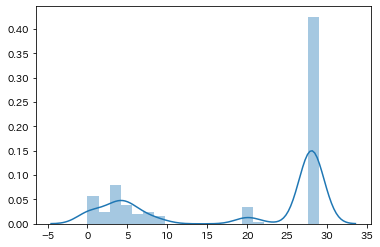

In [16]:
sns.distplot(np.concatenate(train.class_labels))

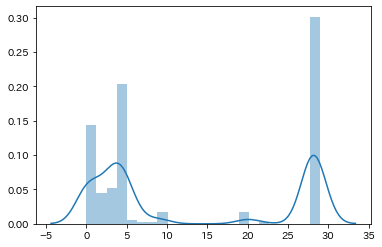

In [17]:
sns.distplot(np.concatenate(valid.class_labels))

In [18]:
train['query_id'].value_counts(dropna=True)

120067     249
75032       67
1169145     21
310736      13
833386      10
          ... 
795153       1
1243666      1
154134       1
285592       1
387633       1
Name: query_id, Length: 9050, dtype: int64

In [19]:
valid['query_id'].value_counts(dropna=True)

495    30
266    30
282    30
290    30
298    30
       ..
415    17
448    17
323    17
351    15
425     9
Name: query_id, Length: 496, dtype: int64

### class_label

In [20]:
train.class_labels.iloc[0]

array([28, 28], dtype=int64)

In [21]:
train.class_labels.iloc[0][:10]

array([28, 28], dtype=int64)

In [22]:
# from sklearn import preprocessing as pp

# lb = pp.LabelBinarizer()
# lb.fit(np.array(range(1,34)))

In [23]:
# lb.transform(np.array([1,2,3]))

In [24]:
# train.class_labels = train.class_labels.swifter.apply(lambda x: lb.transform(x))
# valid.class_labels = valid.class_labels.swifter.apply(lambda x: lb.transform(x))

In [25]:
# train.head()

### boxの大きさ
- [top, left, bottom, right]

In [26]:
train['box_area'] = train.boxes.apply(lambda x: np.array([(xi[2]-xi[0])*(xi[3]-xi[1]) for xi in x]))
valid['box_area'] = valid.boxes.apply(lambda x: np.array([(xi[2]-xi[0])*(xi[3]-xi[1]) for xi in x]))

In [27]:
train.head()

,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id,box_area
0,102851856,338,209,2,"[[0.0, 3.0, 338.0, 207.0], [239.0, 22.0, 333.0...","[[0.0, 0.0, 6.0378604, 0.0, 0.037252333, 0.0, ...","[28, 28]",treble popular reed,923271,"[68952.0, 17108.0]"
1,101783080,80,61,1,"[[5.0, 5.0, 75.0, 56.0]]","[[0.0, 0.015551143, 1.4977295, 0.0, 0.03303502...",[28],compatible ink cartridges,234031,[3570.0]
2,100492797,750,750,1,"[[43.0, 263.0, 658.0, 468.0]]","[[0.0, 0.0, 0.81766355, 0.0, 0.02573972, 0.0, ...",[7],check new look facial cream,199926,[126075.0]
3,101708088,480,640,5,"[[250.0, 421.0, 416.0, 635.0], [252.0, 5.0, 42...","[[0.0, 0.0, 0.0, 0.0, 0.24994667, 0.0, 0.0, 0....","[28, 28, 28, 28, 28]",royal commemorative stamp,772725,"[35524.0, 36993.0, 40936.0, 5472.0, 39078.0]"
4,100316842,800,800,4,"[[138.0, 257.0, 716.0, 540.0], [162.0, 667.0, ...","[[0.0, 0.014258672, 0.02542738, 0.0, 0.0, 0.0,...","[28, 6, 6, 28]",calendula baby shower gel,362576,"[163574.0, 22784.0, 20988.0, 138230.0]"


In [28]:
train.box_area.iloc[4]

array([163574.,  22784.,  20988., 138230.], dtype=float32)

In [29]:
np.argsort(train.box_area.iloc[4])[::-1]  # 降順

array([0, 3, 1, 2], dtype=int64)

In [30]:
train.features.iloc[4]

array([[0.        , 0.01425867, 0.02542738, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0172948 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.6604856 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [31]:
train.features.iloc[4][np.argsort(train.box_area.iloc[4])[::-1], :]

array([[0.        , 0.01425867, 0.02542738, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0172948 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.6604856 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [32]:
train.features.iloc[4][np.argsort(train.box_area.iloc[4])[::-1], :].reshape(-1,)

array([0.        , 0.01425867, 0.02542738, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

### 1画像に1ラベルなにかつける
- metric learningのラベルにしたい
- 同一ラベルは近く、異なるラベルは離れるようにするため


- 今はbox_areaが最大のラベルを割り当てることにする

## word2vec

In [33]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')

In [34]:
train['query'] = train['query'].swifter.apply(lambda x: [w for w in x.split(' ') if w not in stopWords])
valid['query'] = valid['query'].swifter.apply(lambda x: [w for w in x.split(' ') if w not in stopWords])

In [35]:
train.head()

,product_id,image_h,image_w,num_boxes,boxes,features,class_labels,query,query_id,box_area
0,102851856,338,209,2,"[[0.0, 3.0, 338.0, 207.0], [239.0, 22.0, 333.0...","[[0.0, 0.0, 6.0378604, 0.0, 0.037252333, 0.0, ...","[28, 28]","[treble, popular, reed]",923271,"[68952.0, 17108.0]"
1,101783080,80,61,1,"[[5.0, 5.0, 75.0, 56.0]]","[[0.0, 0.015551143, 1.4977295, 0.0, 0.03303502...",[28],"[compatible, ink, cartridges]",234031,[3570.0]
2,100492797,750,750,1,"[[43.0, 263.0, 658.0, 468.0]]","[[0.0, 0.0, 0.81766355, 0.0, 0.02573972, 0.0, ...",[7],"[check, new, look, facial, cream]",199926,[126075.0]
3,101708088,480,640,5,"[[250.0, 421.0, 416.0, 635.0], [252.0, 5.0, 42...","[[0.0, 0.0, 0.0, 0.0, 0.24994667, 0.0, 0.0, 0....","[28, 28, 28, 28, 28]","[royal, commemorative, stamp]",772725,"[35524.0, 36993.0, 40936.0, 5472.0, 39078.0]"
4,100316842,800,800,4,"[[138.0, 257.0, 716.0, 540.0], [162.0, 667.0, ...","[[0.0, 0.014258672, 0.02542738, 0.0, 0.0, 0.0,...","[28, 6, 6, 28]","[calendula, baby, shower, gel]",362576,"[163574.0, 22784.0, 20988.0, 138230.0]"


In [36]:
# Load Google's pre-trained Word2Vec model.
# model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR+'GoogleNews-vectors-negative300.bin', binary=True)

In [37]:
from gensim.scripts.glove2word2vec import glove2word2vec
# _ = glove2word2vec(W2V_DIR+'glove.6B/glove.6B.300d.txt', W2V_DIR+'glove.6B/glove.6B.300d_w2v.txt')

model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR+'glove.6B/glove.6B.300d_w2v.txt')

In [38]:
model_w2v['short-sleeved']

array([ 0.01089  , -0.64106  , -0.19863  , -0.23696  , -0.47266  ,
        0.32067  , -0.44031  ,  0.019803 , -0.21814  ,  0.59546  ,
        0.26734  ,  0.53944  , -0.66176  ,  0.18678  , -0.41743  ,
       -0.4818   ,  0.16942  , -0.64982  ,  0.41209  , -0.25478  ,
       -0.96255  , -0.57953  , -0.23118  ,  0.54267  , -0.80079  ,
       -0.6732   , -0.094272 ,  0.18689  ,  0.3882   , -0.56279  ,
        0.53548  , -0.49303  ,  0.15239  , -0.018012 ,  0.74254  ,
        0.3777   , -0.3247   , -0.38282  ,  0.17707  ,  0.098162 ,
       -0.14701  ,  0.33079  , -0.52109  , -1.1775   ,  0.22824  ,
       -0.053804 , -0.52793  , -0.43674  , -0.23883  , -0.49577  ,
       -0.41427  , -0.082529 ,  0.38079  , -0.13115  ,  0.012661 ,
       -0.058927 , -0.205    , -0.38402  , -0.14487  ,  0.090708 ,
       -0.0026042, -0.68542  , -0.58049  , -0.21262  , -0.65491  ,
       -0.066237 ,  0.41332  , -0.62144  , -1.124    ,  0.27328  ,
        0.37292  ,  0.019297 , -0.64647  , -0.50676  ,  0.0921

In [39]:
def calc_mean_w2v(words_list):
    words_list = filter(lambda x: x in model_w2v.vocab, words_list)
    words_list = [w for w in words_list]
    #print(words_list)
    try:
        return np.mean(model_w2v[words_list], axis=0)
    except:
        return np.ones(300)

In [40]:
train['query'] = train['query'].swifter.apply(calc_mean_w2v)
valid['query'] = valid['query'].swifter.apply(calc_mean_w2v)

### 初期設定

In [41]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

cuda


### DataLoader

In [43]:
MAX_LEN = 10

class KDDDataset(Dataset):

    def __init__(self, df, train_mode=True, transform=None):
        self.df = df
        #self.transform = transform
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # box_areaの大きい順にソート
        box_order = np.argsort(row.box_area)[::-1]
        faetures_ordered = row.features[box_order, :][:MAX_LEN]
        class_labels_ordered = row.class_labels[box_order][:MAX_LEN]
        
        features = pad_sequences([faetures_ordered.reshape(-1,)], maxlen=MAX_LEN*2048, padding='post')
        class_labels = pad_sequences([class_labels_ordered.reshape(-1,)], maxlen=MAX_LEN, value=33, padding='post')
        #features = np.concatenate([features, class_labels], axis=0)
        
        
        # queryのw2vの平均
#         query_vec = np.mean(model_w2v[row['query']], axis=0)
        query_vec = row['query']
        
        return {
                'features': torch.tensor(features, dtype=torch.float).squeeze(),
                'class_labels': torch.tensor(class_labels, dtype=torch.long).squeeze(),
                'query_vec': torch.tensor(query_vec, dtype=torch.float).squeeze(),
        }

In [44]:
def get_train_valid_loaders(df, batch_size=4, val_batch_size=4, ifold=0):

    df = shuffle(df, random_state=1234)
    
    folds = GroupKFold(n_splits=5).split(X=df.query_id, groups=df.query_id)
    for fold, (tr_idx, val_idx) in enumerate(folds):
        if fold == ifold:
            df_tr = df.iloc[tr_idx]
            df_val = df.iloc[val_idx]
            break

    print('train', df_tr.shape)
    print('valid', df_val.shape)

    dataset_train = KDDDataset(df_tr, train_mode=True)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

    dataset_valid = KDDDataset(df_val, train_mode=False)
    valid_loader = DataLoader(dataset_valid, batch_size=val_batch_size, shuffle=False, num_workers=0, drop_last=False)

    return train_loader, valid_loader


# test_dataの場合（queryだけ与えられる場合は、別途書く）
def get_test_loaders(df, batch_size=1):

    dataset_test = KDDDataset(df, train_mode=False)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

    return test_loader

### Model
- imageを処理するモデル
    - featuresを処理する層
    - class_labelsをembeddingする層
- queryを処理するモデル

In [45]:
DIM_FEATURES = 128

In [46]:
class Model_Image(nn.Module):
    def __init__(self):
        super(Model_Image, self).__init__()
        self.model_name = 'Model_images_01'
        
        self.fc_features = nn.Linear(MAX_LEN*2048, 512)
        self.emb_class_labels = nn.Embedding(34, 8)
        self.fc_concat = nn.Linear(512+8, DIM_FEATURES)
        

    def forward(self, features, class_labels):

        out_features = F.relu(self.fc_features(features))
        out_class_labels = F.relu(self.emb_class_labels(class_labels))        
        out_class_labels = out_class_labels[:,0,:].squeeze()
        
        out_features = torch.cat([out_features, out_class_labels], dim=-1)
        out_features = F.dropout(out_features, p=0.2, training=self.training)
        
        out_features = F.relu(self.fc_concat(out_features))

        return out_features

In [47]:
class Model_Query(nn.Module):
    def __init__(self):
        super(Model_Query, self).__init__()
        self.model_name = 'Model_query_01'
        
        self.fc_query = nn.Linear(300, DIM_FEATURES)

    def forward(self, query_vec):
        
        out_query = F.relu(self.fc_query(query_vec))

        return out_query #.unsqueeze(2))

### Loss function

In [48]:
from pytorch_metric_learning import losses

### Training

In [49]:
def train_model(train_loader, model_image, model_query, optimizer, criterion): #, scheduler):
    model_image.train()
    model_query.train()
    avg_loss = 0.
    for idx, batch in enumerate(tqdm(train_loader)):
        features = batch['features'].to(device)
        class_labels = batch['class_labels'].to(device)
        query_vec = batch['query_vec'].to(device)
        
        out_image = model_image(features, class_labels)
        out_query = model_query(query_vec)
        out = torch.bmm(out_image.unsqueeze(1), out_query.unsqueeze(2))
        loss = criterion(out, class_labels[:,0])        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        avg_loss += loss.item() / len(train_loader)
        del features, class_labels, query_vec, out_image, out_query, out, loss

    torch.cuda.empty_cache()
    gc.collect()
    return avg_loss


def valid_model(valid_loader, model_image, model_query):
    model_image.eval()
    model_query.eval()
    avg_loss = 0.
       
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(valid_loader)):
            features = batch['features'].to(device)
            class_labels = batch['class_labels'].to(device)
            query_vec = batch['query_vec'].to(device)
            
            out_image = model_image(features, class_labels)
            out_query = model_query(query_vec)
            out = torch.bmm(out_image.unsqueeze(1), out_query.unsqueeze(2))
            loss = criterion(out, class_labels[:,0])
            
            avg_loss += loss.item() / len(valid_loader)
            del features, class_labels, query_vec, out_image, out_query, out, loss
        
    torch.cuda.empty_cache()
    gc.collect()
    return avg_loss


def test_model(test_loader, model_image, model_query):
    model_image.eval()
    model_query.eval()
    
    out_list = []   
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(test_loader)):
            features = batch['features'].to(device)
            class_labels = batch['class_labels'].to(device)
            query_vec = batch['query_vec'].to(device)
            
            out_image = model_image(features, class_labels)
            out_query = model_query(query_vec)
            out = torch.bmm(out_image.unsqueeze(1), out_query.unsqueeze(2))
            out_list.append(out)
            del features, class_labels, query_vec, out_image, out_query, out
        
    torch.cuda.empty_cache()
    gc.collect()
    return out_list

In [54]:
loss_list_train = []
loss_list_valid = []
for fold in range(3):
    print('---%d-Fold---'%(fold+1))
    
    model_image = Model_Image().to(device)
    model_query = Model_Query().to(device)
    
#     optimizer = torch.optim.Adam(model.parameters())
    optimizer = torch.optim.Adam([
                        {'params': model_image.parameters()},
                        {'params': model_query.parameters()}
                    ])
    
    criterion = losses.TripletMarginLoss(margin=0.1)
    
    loss_list_epoch_train = []
    loss_list_epoch_valid = []
    for epoch in range(20):

        torch.cuda.empty_cache()
        start_time   = time.time()

        train_loader, valid_loader = get_train_valid_loaders(df=train,batch_size=128,val_batch_size=128,ifold=fold)
        #scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=config.warmup, num_training_steps=config.epochs*len(train_loader))

        loss_train = train_model(train_loader, model_image, model_query, optimizer, criterion)#, scheduler)
        loss_valid = valid_model(valid_loader, model_image, model_query)
        
        loss_list_epoch_train.append(loss_train)
        loss_list_epoch_valid.append(loss_valid)
        
        print(f'Epoch {(epoch+1)}, train_loss: {loss_train}, valid_loss: {loss_valid}, time: {(time.time()-start_time)}')

#         if score_val > best_score:
#             best_score = score_val
#             best_param_score = model.state_dict()
#             print('best_param_score_{}_{}.pt'.format(config.name ,fold+1))
#             torch.save(best_param_score, '/content/drive/My Drive/Colab Notebooks/GoogleQuest/best_param_score_{}_{}.pt'.format(config.name ,fold+1))
#         else:
#             patience += 1
#             if patience >= config.patience:
#                 del train_loader, valid_loader, loss_train, loss_val, score_val, preds
#                 torch.cuda.empty_cache()
#                 gc.collect()
#                 break

        del train_loader, valid_loader, loss_train, loss_valid
        torch.cuda.empty_cache()
        gc.collect()
    
    loss_list_train.append(loss_list_epoch_train)
    loss_list_valid.append(loss_list_epoch_valid)

---1-Fold---
train (8000, 10)
valid (2000, 10)



Epoch 1, train_loss: 0.10000000389352919, valid_loss: 0.10000000335276127, time: 9.894969701766968
train (8000, 10)
valid (2000, 10)



Epoch 2, train_loss: 0.15625030919909477, valid_loss: 0.3554464355111122, time: 9.798334121704102
train (8000, 10)
valid (2000, 10)



Epoch 3, train_loss: 0.2836550253052865, valid_loss: 0.44021568074822426, time: 9.592749834060669
train (8000, 10)
valid (2000, 10)



Epoch 4, train_loss: 0.35061202126164587, valid_loss: 0.4367715250700712, time: 9.546502828598022
train (8000, 10)
valid (2000, 10)



Epoch 5, train_loss: 0.33713036631384197, valid_loss: 0.3818342871963978, time: 9.97608470916748
train (8000, 10)
valid (2000, 10)



Epoch 6, train_loss: 0.33764447319892155, valid_loss: 0.144479526206851, time: 9.968189001083374
train (8000, 10)
valid (2000, 10)



Epoch 7, train_loss: 0.3304624259471893, valid_loss: 0.40463938750326633, time: 10.05180311203003
train (8000, 10)
valid (2000, 10)



Epoch 8, train_loss: 0.35015420134990444, valid_loss: 0.407564977183938, time: 9.945722341537476
train (8000, 10)
valid (2000, 10)



Epoch 9, train_loss: 0.31613971653484524, valid_loss: 0.3922626730054617, time: 9.89113998413086
train (8000, 10)
valid (2000, 10)



Epoch 10, train_loss: 0.3586899171913825, valid_loss: 0.41762810945510864, time: 9.728135824203491
train (8000, 10)
valid (2000, 10)



Epoch 11, train_loss: 0.28601512120616057, valid_loss: 0.3694971352815628, time: 9.698105573654175
train (8000, 10)
valid (2000, 10)



Epoch 12, train_loss: 0.34578361770799093, valid_loss: 0.3838961608707905, time: 9.808138608932495
train (8000, 10)
valid (2000, 10)



Epoch 13, train_loss: 0.3453690594723148, valid_loss: 0.34345562383532524, time: 9.674414873123169
train (8000, 10)
valid (2000, 10)



Epoch 14, train_loss: 0.25352799255521075, valid_loss: 0.19952130131423473, time: 9.588632822036743
train (8000, 10)
valid (2000, 10)



Epoch 15, train_loss: 0.29596766180569123, valid_loss: 0.3922129813581705, time: 9.577325105667114
train (8000, 10)
valid (2000, 10)



Epoch 16, train_loss: 0.3314846037856995, valid_loss: 0.3798914924263954, time: 9.615152835845947
train (8000, 10)
valid (2000, 10)



Epoch 17, train_loss: 0.35153806113427677, valid_loss: 0.3717260845005512, time: 9.719721794128418
train (8000, 10)
valid (2000, 10)



Epoch 18, train_loss: 0.34990084171295155, valid_loss: 0.3883987106382847, time: 9.600741863250732
train (8000, 10)
valid (2000, 10)



Epoch 19, train_loss: 0.3301114101083048, valid_loss: 0.3104279153048992, time: 9.495662212371826
train (8000, 10)
valid (2000, 10)



Epoch 20, train_loss: 0.3428069093535022, valid_loss: 0.3981676585972309, time: 9.515504598617554
---2-Fold---
train (8000, 10)
valid (2000, 10)



Epoch 1, train_loss: 0.10283458028589523, valid_loss: 0.13652641233056784, time: 9.499303817749023
train (8000, 10)
valid (2000, 10)



Epoch 2, train_loss: 0.17164768783315537, valid_loss: 0.3387175723910332, time: 9.497533082962036
train (8000, 10)
valid (2000, 10)



Epoch 3, train_loss: 0.26848799374795734, valid_loss: 0.37411487475037575, time: 9.496043682098389
train (8000, 10)
valid (2000, 10)



Epoch 4, train_loss: 0.3374542632410603, valid_loss: 0.3537289425730705, time: 9.440994262695312
train (8000, 10)
valid (2000, 10)



Epoch 5, train_loss: 0.30491350134534223, valid_loss: 0.3905343133956194, time: 9.469789981842041
train (8000, 10)
valid (2000, 10)



Epoch 6, train_loss: 0.34017963443071597, valid_loss: 0.39895270206034184, time: 9.490236759185791
train (8000, 10)
valid (2000, 10)



Epoch 7, train_loss: 0.35308204615308403, valid_loss: 0.40200325101614, time: 9.491901397705078
train (8000, 10)
valid (2000, 10)



Epoch 8, train_loss: 0.35571167401729087, valid_loss: 0.3567076288163662, time: 9.56797170639038
train (8000, 10)
valid (2000, 10)



Epoch 9, train_loss: 0.3554535416826126, valid_loss: 0.4057129379361868, time: 9.526089906692505
train (8000, 10)
valid (2000, 10)



Epoch 10, train_loss: 0.35954900133994316, valid_loss: 0.35431715473532677, time: 9.45869255065918
train (8000, 10)
valid (2000, 10)



Epoch 11, train_loss: 0.3362245838488302, valid_loss: 0.36760167591273785, time: 9.5061674118042
train (8000, 10)
valid (2000, 10)



Epoch 12, train_loss: 0.35531186288402933, valid_loss: 0.3788834325969219, time: 9.49630880355835
train (8000, 10)
valid (2000, 10)



Epoch 13, train_loss: 0.351066421116552, valid_loss: 0.349977221339941, time: 9.470595121383667
train (8000, 10)
valid (2000, 10)



Epoch 14, train_loss: 0.35288641000947635, valid_loss: 0.41131073981523514, time: 9.49416732788086
train (8000, 10)
valid (2000, 10)



Epoch 15, train_loss: 0.35911897449724123, valid_loss: 0.35936612635850906, time: 9.484270334243774
train (8000, 10)
valid (2000, 10)



Epoch 16, train_loss: 0.356497480984657, valid_loss: 0.3699544910341501, time: 9.463443994522095
train (8000, 10)
valid (2000, 10)



Epoch 17, train_loss: 0.3218978451144311, valid_loss: 0.3720988351851702, time: 9.501855850219727
train (8000, 10)
valid (2000, 10)



Epoch 18, train_loss: 0.362872276094652, valid_loss: 0.36030145175755024, time: 9.48055100440979
train (8000, 10)
valid (2000, 10)



Epoch 19, train_loss: 0.3206416560757544, valid_loss: 0.38110988214612007, time: 9.500051498413086
train (8000, 10)
valid (2000, 10)



Epoch 20, train_loss: 0.36672791261826787, valid_loss: 0.3850659541785717, time: 9.47359037399292
---3-Fold---
train (8000, 10)
valid (2000, 10)



Epoch 1, train_loss: 0.10339258707338764, valid_loss: 0.18174493871629238, time: 9.498628616333008
train (8000, 10)
valid (2000, 10)



Epoch 2, train_loss: 0.20228972958941613, valid_loss: 0.3984614070504904, time: 9.53191590309143
train (8000, 10)
valid (2000, 10)



Epoch 3, train_loss: 0.33704149482711665, valid_loss: 0.4011239893734455, time: 9.486079692840576
train (8000, 10)
valid (2000, 10)



Epoch 4, train_loss: 0.3472884268529953, valid_loss: 0.2819454185664654, time: 9.507444381713867
train (8000, 10)
valid (2000, 10)



Epoch 5, train_loss: 0.30026575814812423, valid_loss: 0.4431758876889944, time: 9.493910789489746
train (8000, 10)
valid (2000, 10)



Epoch 6, train_loss: 0.3098650942406347, valid_loss: 0.38640132173895836, time: 9.467121124267578
train (8000, 10)
valid (2000, 10)



Epoch 7, train_loss: 0.3286310516057475, valid_loss: 0.35804977640509605, time: 9.492170572280884
train (8000, 10)
valid (2000, 10)



Epoch 8, train_loss: 0.3467928663857522, valid_loss: 0.3251007180660963, time: 9.542524814605713
train (8000, 10)
valid (2000, 10)



Epoch 9, train_loss: 0.3469660844533673, valid_loss: 0.40802603773772717, time: 9.495785236358643
train (8000, 10)
valid (2000, 10)



Epoch 10, train_loss: 0.3221725448966026, valid_loss: 0.3929827567189932, time: 9.530924081802368
train (8000, 10)
valid (2000, 10)



Epoch 11, train_loss: 0.3541002259139093, valid_loss: 0.3086443990468979, time: 9.499951362609863
train (8000, 10)
valid (2000, 10)



Epoch 12, train_loss: 0.31929199061086105, valid_loss: 0.4042071122676134, time: 9.519401788711548
train (8000, 10)
valid (2000, 10)



Epoch 13, train_loss: 0.2489225598833253, valid_loss: 0.21132295206189156, time: 9.520739555358887
train (8000, 10)
valid (2000, 10)



Epoch 14, train_loss: 0.30601554508170775, valid_loss: 0.4094775151461363, time: 9.48860502243042
train (8000, 10)
valid (2000, 10)



Epoch 15, train_loss: 0.32893873342583274, valid_loss: 0.3507482688874006, time: 9.556471586227417
train (8000, 10)
valid (2000, 10)



Epoch 16, train_loss: 0.337782808369206, valid_loss: 0.36415242962539196, time: 9.459723472595215
train (8000, 10)
valid (2000, 10)



Epoch 17, train_loss: 0.3319483649346136, valid_loss: 0.3281013946980238, time: 9.485703945159912
train (8000, 10)
valid (2000, 10)



Epoch 18, train_loss: 0.34691014261015, valid_loss: 0.3608162887394428, time: 9.461026668548584
train (8000, 10)
valid (2000, 10)



Epoch 19, train_loss: 0.32054481967802967, valid_loss: 0.2054919470101595, time: 9.499288320541382
train (8000, 10)
valid (2000, 10)



Epoch 20, train_loss: 0.2665694973641827, valid_loss: 0.2883451944217086, time: 9.559422731399536


### Evaluation
- 各クエリに対して、約30個程度の画像が用意されている
- 

In [55]:
def make_submit_df(df_test, model_image, model_query):
    test_loader = get_test_loaders(df_test, batch_size=128)
    out_list = test_model(test_loader, model_image, model_query)

    for i, out in enumerate(out_list):
        if i==0:
            out_array = out.squeeze()
        else:
            out_array = torch.cat([out_array, out.squeeze()], dim=-1)

    out_array = out_array.cpu().detach().numpy()
    df_test['score'] = out_array
    
    # sort and group by
    df_test = df_test.sort_values(by="score", ascending=False)
    grouped = df_test.groupby("query_id").head(5)
    
    submit_df = pd.DataFrame(columns=['query-id','product1','product2','product3','product4','product5'])
    for i, q_id in enumerate(tqdm(grouped['query_id'].unique())):
        submit_df.loc[i, 'query-id'] = q_id
        submit_df.iloc[i, 1:] = grouped.loc[(grouped['query_id']==q_id), 'product_id'].values
    submit_df = submit_df.astype(int)
    submit_df = submit_df.sort_values(by='query-id')
    submit_df = submit_df.reset_index(drop=True)
    
    return submit_df

In [56]:
valid_df = make_submit_df(valid, model_image, model_query)

In [57]:
valid_df

,query-id,product1,product2,product3,product4,product5
0,0,103035435,103051756,103061530,103001388,103030678
1,1,103049171,103015195,103021626,103037602,103058364
2,2,103059018,103020043,103035690,103062605,103001803
3,3,103038025,103010833,103034297,100839691,103037089
4,4,103022601,103048840,103007030,103028489,103028674
...,...,...,...,...,...,...
491,496,103039754,103038851,103017742,103023873,103055292
492,497,103010228,103061897,103040596,103059758,103029501
493,498,103025926,103035595,103007452,103029931,103007795
494,499,103004211,103066828,103040130,103016696,103022168


In [58]:
import json
with open(DATA_DIR+'multimodal_valid/'+'valid_answer.json') as f:
    valid_answer = json.load(f)
valid_answer

{'0': [103059361, 103020398, 103017048, 103020893, 103031217, 103027983],
 '1': [103006221, 103021626, 103058364, 103004286, 103037602, 103031934],
 '2': [103057259, 103008379, 103056701, 103020043, 103059018, 103032818],
 '3': [103039690, 103047054, 103045847, 103043416, 103040728, 103041248],
 '4': [103041391, 103020465, 103042861, 103000889, 103034565, 103018943],
 '5': [103054968, 103042912, 103061609, 103054576, 103007463, 103022151],
 '6': [103021733, 103005137, 103032874, 103057624, 103016708, 103053800],
 '7': [103018229, 103065006, 103001819, 103029600, 103013625, 103061390],
 '8': [103052237, 103007467, 103027357, 103056233, 103027289, 103011213],
 '9': [103038057, 103064965, 103026604, 103030456, 103046297, 103010304],
 '10': [103018933, 103032226, 103065206, 103005840, 103049707],
 '11': [103028765, 103052758, 103056361, 103058508],
 '12': [103032272, 103014741, 103058210, 103048088, 103008191, 103034577],
 '13': [103064962, 103000619, 103004698, 103004351, 103056700, 10302

In [59]:
# 答え合わせ
dcg5_list = []
for k, v in valid_answer.items():
    dcg5_local = 0
    for i in range(5):
        if valid_df.loc[valid_df['query-id']==int(0), :].values[:, (i+1)][0] in v:
            dcg5_local += 1/np.log2(i+1+1)
    dcg5_list.append(dcg5_local)
    
np.mean(dcg5_list)

0.0

In [ ]:
for i, out in enumerate(out_list):
    if i==0:
        out_array = out.squeeze()
    else:
        out_array = torch.cat([out_array, out.squeeze()], dim=-1)

out_array = out_array.cpu().detach().numpy()

In [ ]:
valid['score'] = out_array

In [ ]:
# sort
valid = valid.sort_values(by="score", ascending=False)
display(valid)
# # group by
grouped = valid.groupby("query_id").head(5)
display(grouped)

In [ ]:
grouped['query_id'].value_counts(dropna=False)

In [ ]:
grouped.groupby('query_id')[['product_id']].count()

In [ ]:
submit_df = pd.DataFrame(columns=['query-id','product1','product2','product3','product4','product5'])
for i, q_id in enumerate(tqdm(grouped['query_id'].unique())):
    submit_df.loc[i, 'query-id'] = q_id
    submit_df.iloc[i, 1:] = grouped.loc[(grouped['query_id']==q_id), 'product_id'].values
submit_df = submit_df.astype(int)
submit_df = submit_df.sort_values(by='query-id')
submit_df = submit_df.reset_index(drop=True)

In [ ]:
submit_df

In [ ]:
import json
with open(DATA_DIR+'multimodal_valid/'+'valid_answer.json') as f:
    valid_answer = json.load(f)
valid_answer

In [ ]:
vald_answer_df = pd.DataFrame(columns=['query-id','product1','product2','product3','product4','product5'])
for i, (k,v) in enumerate(tqdm(valid_answer.items())):
    vald_answer_df.loc[i, 'query-id'] = k
    vald_answer_df.iloc[i, 1:] = v

In [ ]:
len(valid_answer)

## ※Try and Error

In [ ]:
a = torch.randn((4,10,8))

In [ ]:
F.avg_pool1d(a.transpose(1,2), kernel_size=a.size()[1]).squeeze().shape

In [ ]:
a

In [ ]:
a = torch.randn(4,10)
b = torch.randn(4,10)

In [ ]:
a

In [ ]:
b

In [ ]:
a.view(4,1,10)

In [ ]:
torch.bmm(a.view(4,1,10), b.view(4,10,1))

In [ ]:
torch.bmm(a.view(4,1,10),b.view(4,10,1)

In [ ]:
a = torch.randn((4, 1))
a

In [ ]:
b = torch.tensor(np.array([1,2,3,4]))
b.shape

In [ ]:
loss = criterion(a, b) 
loss.item()